In [2]:
import matplotlib.pyplot as plt
import sklearn
import nltk
import scipy.sparse
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics
from itertools import chain
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import csv
from pathlib import Path
import regex as re

In [ ]:
def pos_tagging(text):
    value = nltk.pos_tag(text)
    return value

In [ ]:
def read_wnut(file_path):
    file_path = Path(file_path)
    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    for doc in raw_docs:
        values = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            values.append((token,pos_tagging(list(token)), tag))
        token_docs.append(values)

    return token_docs

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    # print(word, postag, i)

    features = {
        "bias": 1.0,
        "word.lower()": word.lower(),
        "word[-3:]": word[-3:],
        "word[-2:]": word[-2:],
        "word.isupper()": word.isupper(),
        "word.istitle()": word.istitle(),
        "word.isdigit()": word.isdigit(),
        "postag": postag,
        "postag[:2]": postag[:2],
    }

    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        # print(f" i > 0 : {word1} {postag1} {i}")
        features.update(
            {
                "-1:word.lower()": word1.lower(),
                "-1:word.istitle()": word1.istitle(),
                "-1:word.isupper()": word1.isupper(),
                "-1:postag": postag1,
                "-1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["BOS"] = True

    if i < (len(sent) - 1):
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        # print(f" i < len : {word1} {postag1} {i}")
        features.update(
            {
                "+1:word.lower()": word1.lower(),
                "+1:word.istitle()": word1.istitle(),
                "+1:word.isupper()": word1.isupper(),
                "+1:postag": postag1,
                "+1:postag[:2]": postag1[:2],
            }
        )
    else:
        features["EOS"] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, postag, label in sent]


def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [ ]:
train_data = read_wnut('./data/wnut17train.conll')
test_data = read_wnut('./data/wnut17train.conll')

In [ ]:

X_train = [sent2features(s) for s in train_data]
y_train = [sent2labels(s) for s in train_data]

X_test = [sent2features(s) for s in test_data]
y_test = [sent2labels(s) for s in test_data]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

TypeError: expected bytes, tuple found

In [ ]:
labels = list(crf.classes_)
labels.remove('O')

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average="weighted", labels=labels)

0.9806372917070767

In [ ]:
sorted_labels = sorted(labels, key=lambda name : (name[1:], name[0]))
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

                 precision    recall  f1-score   support

  B-corporation      0.981     0.959     0.970       221
  I-corporation      0.978     0.978     0.978        46
B-creative-work      1.000     0.907     0.951       140
I-creative-work      1.000     0.971     0.985       206
        B-group      0.992     0.943     0.967       264
        I-group      0.993     0.980     0.987       150
     B-location      0.991     0.971     0.981       548
     I-location      0.996     0.988     0.992       245
       B-person      0.997     0.964     0.980       660
       I-person      1.000     0.991     0.996       335
      B-product      1.000     0.930     0.964       142
      I-product      0.995     1.000     0.998       203

      micro avg      0.994     0.967     0.981      3160
      macro avg      0.994     0.965     0.979      3160
   weighted avg      0.994     0.967     0.981      3160



In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs", max_iterations=100, all_possible_transitions=True
)

params_space = {
    "c1": scipy.stats.expon(scale=0.5),
    "c2": scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

random_search = RandomizedSearchCV(
    crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=50, scoring=f1_scorer
)

In [ ]:
Dev_set = read_wnut('./data/wnut17train.conll')

In [ ]:
Dev_X_train = [sent2features(s) for s in Dev_set]
Dev_y_train = [sent2labels(s) for s in Dev_set]

In [ ]:
rs = random_search.fit(Dev_X_train, Dev_y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.014476770305561734, 'c2': 0.013872126208306185}
best CV score: 0.38409307543250204
model size: 1.03M


In [ ]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

Dark blue => 0.2205, dark red => 0.3841


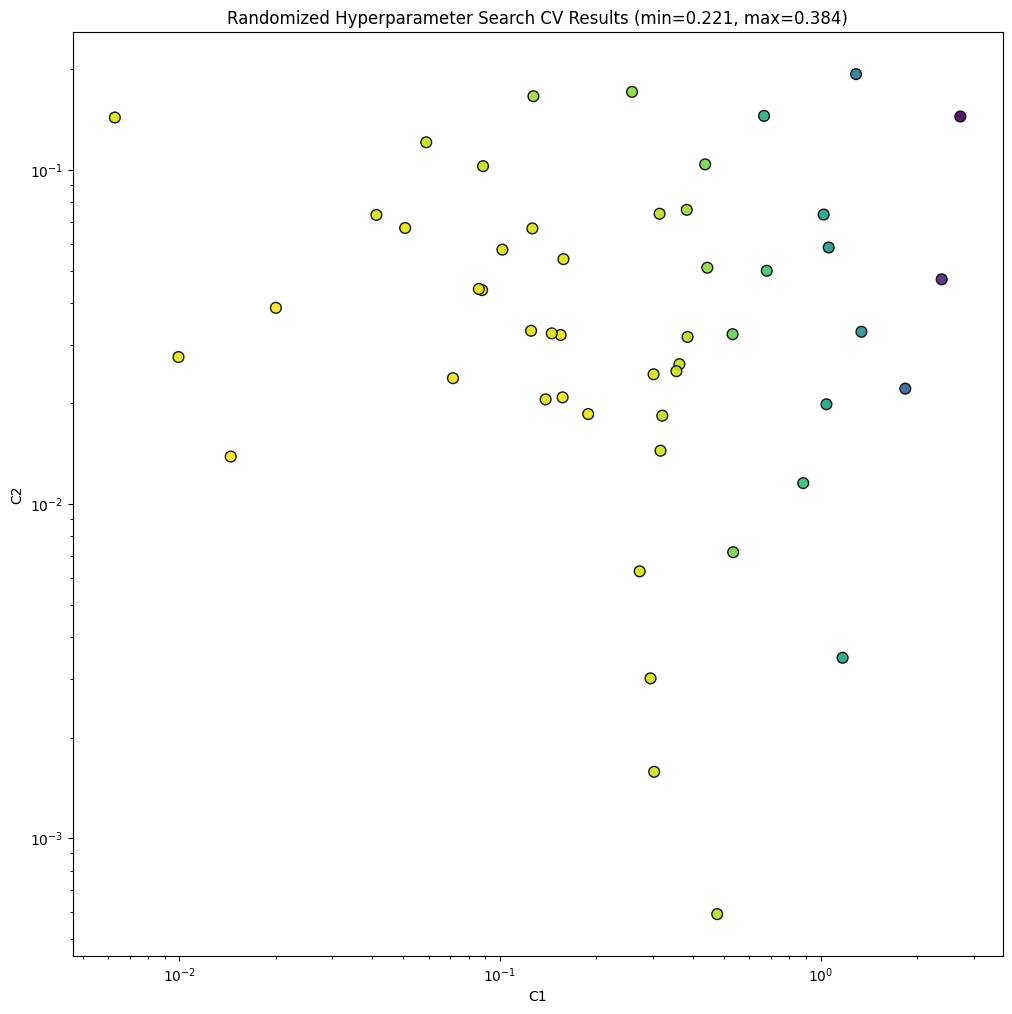

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)  # type: ignore
print(
    metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
)

                 precision    recall  f1-score   support

  B-corporation      0.991     0.991     0.991       221
  I-corporation      0.978     0.978     0.978        46
B-creative-work      0.972     0.986     0.979       140
I-creative-work      0.981     0.995     0.988       206
        B-group      0.989     0.996     0.992       264
        I-group      0.987     1.000     0.993       150
     B-location      0.991     0.995     0.993       548
     I-location      0.992     0.996     0.994       245
       B-person      1.000     0.995     0.998       660
       I-person      1.000     0.997     0.999       335
      B-product      1.000     0.986     0.993       142
      I-product      0.995     1.000     0.998       203

      micro avg      0.992     0.995     0.994      3160
      macro avg      0.990     0.993     0.991      3160
   weighted avg      0.992     0.995     0.994      3160



In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-creative-work -> I-creative-work 7.241130
I-creative-work -> I-creative-work 7.236843
B-product -> I-product 6.922156
I-product -> I-product 6.225378
B-group -> I-group 5.493527
I-group -> I-group 4.842870
B-person -> I-person 4.711837
B-location -> I-location 4.696495
B-corporation -> I-corporation 4.417558
I-location -> I-location 4.369159
I-corporation -> I-corporation 3.931368
O      -> O       2.771898
I-person -> I-person 1.708145
O      -> B-person 1.091969
O      -> B-location 0.877485
B-corporation -> B-location 0.827051
B-group -> B-creative-work 0.762140
O      -> B-corporation 0.756852
I-corporation -> B-location 0.564009
O      -> B-product 0.535566

Top unlikely transitions:
I-person -> B-corporation -1.682054
I-product -> B-person -1.714494
B-location -> B-person -1.735542
B-group -> I-person -1.740712
B-corporation -> I-person -1.764542
B-location -> B-corporation -1.764591
I-location -> I-person -1.847221
B-person -> I-group -1.902308
B-locati

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
11.455325 B-corporation word.lower():twitter
8.566886 B-person word.lower():pope
8.132649 B-product word.lower():iphone
7.810512 B-person word.lower():4dbling
6.900143 B-corporation word.lower():facebook
6.876741 B-location word.lower():jupiter
6.857922 B-location word.lower():perth
6.807479 B-corporation word.lower():walmart
6.567841 B-location +1:word.lower():congressman
6.350318 B-location word.lower():#denver
5.677665 B-person word.lower():florence
5.677177 B-person word.lower():beyonce
5.636719 B-person word.lower():ellwood
5.483996 B-location word.lower():peppers
5.388610 B-location word.lower():bahamas
5.328136 B-product word.lower():pringles
5.193077 B-product word.lower():applemagazine
5.189721 B-corporation word.lower():snapchat
5.165859 B-location word.lower():inverness
5.165859 B-location -1:word.lower():tae
5.157932 B-group  word.lower():astronomerswithoutborders
5.053131 B-person word.lower():billy
4.991559 B-group  word.lower():#buckeyes
4.971040 B-person w